# Метрики

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [399]:
df = pd.read_csv('./athletes.csv')
df = df[df['weight'].notna()]
df = df[df['height'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [400]:
def my_metrics(predictions, real, threshold = 0.5):
    tp, tn, fp, fn = 0, 0, 0, 0

    for predicted_proba, actual in zip(predictions[:, 1], real):
        if predicted_proba >= threshold: predicted = 1 
        else: predicted = 0

        if predicted == 1:
            if actual == 1:  tp += 1
            else:            fp += 1
        else:
            if actual == 1:  fn += 1
            else:            tn += 1

    cm = np.array([ 
        [tn, fp], 
        [fn, tp] 
    ])

    accuracy  = (tn + tp) / (tn + tp + fn + fp) if tn + tp + fn + fp > 0 else 0
    precision = tp / (tp + fp)                  if tp + fp > 0 else 0
    recall    = tp / (tp + fn)                  if tp + fn > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    fpr       = fp / (tn + fp)                  if tn + fp > 0 else 0
    tpr       = tp / (tp + fn)                  if tp + fp > 0 else 0


    return dict(
        threshold=threshold, 
        confusion_matrix = cm,
        tn=tn, 
        fp=fp, 
        tp=tp, 
        fn=fn,
        accuracy = accuracy,
        precision=precision,
        recall=recall,
        f1 = f1,
        fpr = fpr,
        tpr = tpr
    )
    

In [401]:
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline



y_pred = df[['height', 'weight']]

le = LabelEncoder()
y_real_le = le.fit_transform(df[['sex']])

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression('l2', solver='liblinear', random_state=31337)
)

X_train, X_test, y_train, y_test = train_test_split(
    y_pred, 
    y_real_le, 
    train_size=0.8, 
    random_state=31337
)
pipeline.fit( X_train, y_train )
# pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

predictions_proba_test = pipeline.predict_proba(X_test)
predictions_test       = pipeline.predict(X_test)
predictions_proba_tain = pipeline.predict_proba(X_train)
predictions_train      = pipeline.predict(X_train)


c:\Users\avy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [402]:
from sklearn.metrics import confusion_matrix as sk_confussion_matrix, accuracy_score, precision_score, recall_score, f1_score

mm = my_metrics( pipeline.predict_proba(X_train), y_train, 0.5 )

print( mm['confusion_matrix'] )
print( sk_confussion_matrix(y_train, predictions_train) )

print( mm['accuracy'],  accuracy_score(y_train, predictions_train ) )
print( mm['precision'], precision_score(y_train, predictions_train ) )
print( mm['recall'],    recall_score(y_train, predictions_train ) )
print( mm['f1'],        f1_score(y_train, predictions_train ) )


[[3088  940]
 [1021 3637]]
[[3088  940]
 [1021 3637]]
0.7742344001842044 0.7742344001842044
0.794625300415119 0.794625300415119
0.7808072133963074 0.7808072133963074
0.7876556578234976 0.7876556578234976


In [403]:
metrics_space = []
for s in np.arange(0.0, 1, 0.01):
    m = my_metrics( pipeline.predict_proba(X_test), y_test, s )
    metrics_space.append(m)

mdf = pd.DataFrame((metrics_space))
mdf.iloc[::5,]

,threshold,confusion_matrix,tn,fp,tp,fn,accuracy,precision,recall,f1,fpr,tpr
0,0.00,"[[0, 968], [0, 1204]]",0,968,1204,0,0.554328,0.554328,1.000000,0.713270,1.000000,1.000000
5,0.05,"[[34, 934], [0, 1204]]",34,934,1204,0,0.569982,0.563143,1.000000,0.720527,0.964876,1.000000
10,0.10,"[[133, 835], [7, 1197]]",133,835,1197,7,0.612339,0.589075,0.994186,0.739802,0.862603,0.994186
15,0.15,"[[230, 738], [27, 1177]]",230,738,1177,27,0.647790,0.614621,0.977575,0.754729,0.762397,0.977575
20,0.20,"[[348, 620], [56, 1148]]",348,620,1148,56,0.688766,0.649321,0.953488,0.772544,0.640496,0.953488
25,0.25,"[[435, 533], [84, 1120]]",435,533,1120,84,0.715930,0.677556,0.930233,0.784039,0.550620,0.930233
30,0.30,"[[515, 453], [107, 1097]]",515,453,1097,107,0.742173,0.707742,0.911130,0.796659,0.467975,0.911130
35,0.35,"[[571, 397], [146, 1058]]",571,397,1058,146,0.750000,0.727148,0.878738,0.795788,0.410124,0.878738
40,0.40,"[[622, 346], [185, 1019]]",622,346,1019,185,0.755525,0.746520,0.846346,0.793305,0.357438,0.846346
45,0.45,"[[686, 282], [219, 985]]",686,282,985,219,0.769337,0.777427,0.818106,0.797248,0.291322,0.818106


In [404]:
mdf.describe()

,threshold,tn,fp,tp,fn,accuracy,precision,recall,f1,fpr,tpr
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.495000,627.180000,340.820000,859.050000,344.950000,0.684268,0.776719,0.713497,0.687712,0.352087,0.713497
std,0.290115,297.842287,297.842287,314.640195,314.640195,0.079240,0.125916,0.261329,0.157322,0.307688,0.261329
min,0.000000,0.000000,2.000000,49.000000,0.000000,0.467311,0.554328,0.040698,0.078088,0.002066,0.040698
25%,0.247500,431.250000,93.250000,660.500000,81.500000,0.626036,0.676522,0.548588,0.674747,0.096333,0.548588
50%,0.495000,722.500000,245.500000,934.500000,269.500000,0.711096,0.792281,0.776163,0.751466,0.253616,0.776163
75%,0.742500,874.750000,536.750000,1122.500000,543.500000,0.753108,0.876291,0.932309,0.784074,0.554494,0.932309
max,0.990000,966.000000,968.000000,1204.000000,1155.000000,0.770718,0.977099,1.000000,0.800148,1.000000,1.000000


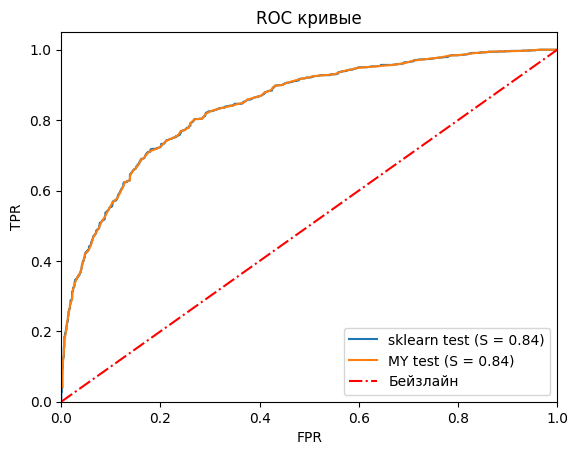

In [409]:
from sklearn.metrics import roc_curve, auc
sk_y_pred_proba_test = pipeline.predict_proba( X_test )
sk_y_pred_proba_train = pipeline.predict_proba( X_train )

fpr, tpr, thresholds    = roc_curve(y_test,  sk_y_pred_proba_test[:,1])
fprt, tprt, thresholdst = roc_curve(y_train, sk_y_pred_proba_train[:,1]) 

roc_auc = auc(fpr, tpr)
roc_auct = auc(fprt, tprt)

my_fpr = list(map(lambda x: x['fpr'], metrics_space))
my_tpr = list(map(lambda x: x['tpr'], metrics_space))
my_roc_auc = auc(my_fpr, my_tpr)
plt.figure()  
plt.plot(fpr, tpr,   label='sklearn test (S = %0.2f)' % roc_auc)
# plt.plot(fprt, tprt, label='sklearn train(S = %0.2f)' % roc_auct)

# plt.plot(my_fpr, my_tpr, label='MY train (S = %0.2f)' % my_roc_auc)
plt.plot(my_fpr, my_tpr, label='MY test (S = %0.2f)' % my_roc_auc)

plt.plot([0, 1], [0, 1], 'r-.', label='Бейзлайн')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривые')
plt.legend()
plt.show()

Ха! Один в один! 😀

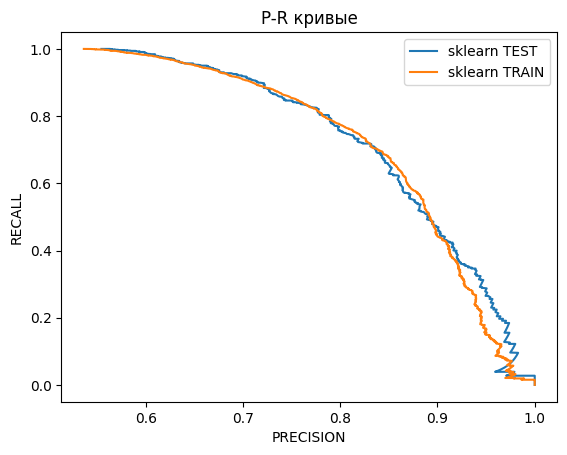

In [406]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve



prt, rct, thresholds = precision_recall_curve(y_test, sk_y_pred_proba_test[:,1]) 
pr, rc, thresholds   = precision_recall_curve(y_train, sk_y_pred_proba_train[:,1]) 

#roc_auc = auc(fpr, tpr)
#my_fpr = list(map(lambda x: x['fpr'], metrics_space))
#my_tpr = list(map(lambda x: x['tpr'], metrics_space))
#my_roc_auc = auc(my_fpr, my_tpr)
plt.figure()  
plt.plot(prt, rct, label='sklearn TEST')
plt.plot(pr, rc, label='sklearn TRAIN')

#plt.plot(my_fpr, my_tpr, label='MY (S = %0.2f)' % my_roc_auc)
#plt.plot([1, 0], [0, 1], 'r-.', label='Бейзлайн')
# plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('PRECISION')
plt.ylabel('RECALL')
plt.title('P-R кривые')
plt.legend()
plt.show()